# Modélisation

In [1]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

# Load configuration
sys.path.append("../")

from utils import RANDOM_STATE, TEST_SIZE

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Load the data
df = pd.read_csv("../data/train_data.csv")
df.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [4]:
y = df.pop("Exited")
X = df.copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"The X_train set contains: {X_train.shape} elements")
print(f"The y_train set contains: {y_train.shape} elements")
print(f"The X_test set contains: {X_test.shape} elements")
print(f"The y_test set contains: {y_test.shape} elements")

The X_train set contains: (114863, 13) elements
The y_train set contains: (114863,) elements
The X_test set contains: (28716, 13) elements
The y_test set contains: (28716,) elements


## Pipeline

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn import set_config

set_config(transform_output="pandas")

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin, check_is_fitted
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import chi2
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import (
    Binarizer,
    OrdinalEncoder,
    PowerTransformer,
)


# Custom transformer for Gaussian Mixture
class GaussianMixtureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.gm = GaussianMixture(
            n_components=self.n_components, random_state=self.random_state
        )

    def fit(self, X, y=None):
        self.gm.fit(X)
        return self

    def transform(self, X):
        # Check if the transformer is fitted
        check_is_fitted(self, ["gm"])
        # Transform the data using the fitted Gaussian Mixture model
        return self.gm.predict_proba(X)


# numerical_features = ["CreditScore", "EstimatedSalary", "Age", "Balance"]
numerical_features = ["CreditScore", "EstimatedSalary"]
onehot_categorical_features = [
    "Geography",
    "Gender",
    "IsActiveMember",
]

ordinal_features = [
    "Tenure",
    "NumOfProducts",
]

n_components_dict = {
    "Age": 2,
    "CreditScore": 9,
    "EstimatedSalary": 5,
    "Balance": 2,
}

# Create separate pipelines for each feature
transformers = []
for feature in numerical_features:
    pipeline = Pipeline(
        steps=[
            (
                "feature_engineering",
                GaussianMixtureTransformer(n_components=n_components_dict[feature]),
            ),
        ]
    )
    transformers.append((f"{feature}_pipeline", pipeline, [feature]))

base_numerical_pipeline = Pipeline(
    steps=[
        ("power_transformation", PowerTransformer(method="yeo-johnson")),
    ]
)

zero_or_not_pipeline = Pipeline(steps=[("discretisation", Binarizer())])

transformers.append(("base_numerical_pipeline", base_numerical_pipeline, ["Age"]))
transformers.append(("limite_solde", zero_or_not_pipeline, ["Balance"]))

numerical_transformer = ColumnTransformer(
    transformers=transformers,
    verbose_feature_names_out=False,
)

categorical_pipeline = ColumnTransformer(
    transformers=[
        (
            "onehot_encoder",
            OneHotEncoder(drop="first", sparse_output=False),
            onehot_categorical_features,
        ),
        (
            "ordinal_encoder",
            OrdinalEncoder(),
            ordinal_features,
        ),
    ],
    verbose_feature_names_out=False,
)

# Create the ColumnTransformer
numerical_preprocessor = ColumnTransformer(
    transformers=transformers, verbose_feature_names_out=False
)


# Custom transformer for LocalOutlierFactor
class OutlierDetector(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1, n_neighbors=20):
        self.contamination = contamination
        self.n_neighbors = n_neighbors
        self.lof = LocalOutlierFactor(
            n_neighbors=self.n_neighbors,
            contamination=self.contamination,
            novelty=True,  # This allows transform to work
        )

    def fit(self, X, y=None):
        self.lof.fit(X)
        return self

    def transform(self, X):
        # Get the negative outlier factor
        outlier_scores = self.lof.decision_function(X)
        # Keep only the data for non-outliers
        return X


numerical_pipeline = Pipeline(
    steps=[
        ("preprocessor", numerical_preprocessor),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = FeatureUnion(
    transformer_list=[
        ("numerical", numerical_pipeline),
        ("categorical", categorical_pipeline),
    ]
)

estimator = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
        # ("outlier_detector", OutlierDetector(contamination=0.05)),
        # ("scaler", MinMaxScaler()),
        # ("final_scaler", MinMaxScaler()),
        # ("feature_selection", SelectKBest(score_func=chi2, k=20)),
        (
            "classifier",
            GradientBoostingClassifier(
                criterion="friedman_mse",
                loss="exponential",
                learning_rate=0.1,
                n_estimators=200,
            ),
        ),
    ]
)

In [33]:
estimator.get_params()['steps']

[('preprocessor',
  FeatureUnion(transformer_list=[('numerical',
                                  Pipeline(steps=[('preprocessor',
                                                   ColumnTransformer(transformers=[('CreditScore_pipeline',
                                                                                    Pipeline(steps=[('feature_engineering',
                                                                                                     GaussianMixtureTransformer(n_components=9))]),
                                                                                    ['CreditScore']),
                                                                                   ('EstimatedSalary_pipeline',
                                                                                    Pipeline(steps=[('feature_engineering',
                                                                                                     GaussianMixtureTransformer(n_components=5))]),
  

In [34]:
estimator

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('preprocessor',
                                                                  ColumnTransformer(transformers=[('CreditScore_pipeline',
                                                                                                   Pipeline(steps=[('feature_engineering',
                                                                                                                    GaussianMixtureTransformer(n_components=9))]),
                                                                                                   ['CreditScore']),
                                                                                                  ('EstimatedSalary_pipeline',
                                                                                                   Pipeline(steps=[('feature_engineering',
                                                                                                                    GaussianMixtureTr...
                                                                  StandardScaler())])),
                                                ('categorical',
                                                 ColumnTransformer(transformers=[('onehot_encoder',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['Geography',
                                                                                   'Gender',
                                                                                   'IsActiveMember']),
                                                                                 ('ordinal_encoder',
                                                                                  OrdinalEncoder(),
                                                                                  ['Tenure',
                                                                                   'NumOfProducts'])],
                                                                   verbose_feature_names_out=False))])),
                ('classifier',
                 GradientBoostingClassifier(loss='exponential',
                                            n_estimators=200))])

In [36]:
from sklearn.model_selection import GridSearchCV



param_grid = [
    {
        # "polynomial_features__degree": [2],
        # "feature_selection__k": [20],
        "classifier__n_estimators": [1200],
    }
]

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator,
    param_grid,
    scoring="f1",
    cv=3,  # Adjust cross-validation folds as needed
    verbose=2,
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Évaluation du modèle sur le jeu de test
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ......................classifier__n_estimators=1200; total time= 2.4min
[CV] END ......................classifier__n_estimators=1200; total time= 2.3min
[CV] END ......................classifier__n_estimators=1200; total time= 2.4min
Best parameters: {'classifier__n_estimators': 1200}
Best F1-score: 0.6370831505043109
Test set score: 0.8619584900403956


In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Extract all results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Create a figure to visualize model performance
plt.figure(figsize=(12, 8))

# Plot F1 scores for different k values
x = np.arange(len(results['param_feature_selection__k'].unique()))
width = 0.3

# Format the results for plotting
mean_scores = results.pivot_table(
    values='mean_test_score', 
    index='param_feature_selection__k',
    columns='param_classifier__n_estimators'
)

# Plot the bars
bars = plt.bar(x, mean_scores.iloc[:, 0], width, label=f'n_estimators={mean_scores.columns[0]}')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
             f'{mean_scores.iloc[i, 0]:.3f}', 
             ha='center', va='bottom', rotation=0)

# Add labels and title
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean F1 Score')
plt.title('Model Performance Comparison')
plt.xticks(x, mean_scores.index)
plt.ylim(0, max(mean_scores.iloc[:, 0]) * 1.1)  # Add some space above the bars
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at the best score
plt.axhline(y=grid_search.best_score_, color='r', linestyle='--', 
           label=f'Best Score: {grid_search.best_score_:.3f}')

# Add information about the best model
plt.annotate(f"Best model: k={grid_search.best_params_['feature_selection__k']}, "
             f"n_estimators={grid_search.best_params_['classifier__n_estimators']}",
             xy=(0.5, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8),
             ha='center', va='center')

# Add test score information
plt.annotate(f"Test set score: {test_score:.3f}",
             xy=(0.5, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.8),
             ha='center', va='center')

plt.legend()
plt.tight_layout()
plt.show()

# # Display feature importance if available
# if hasattr(best_model[-1], 'feature_importances_'):
#     # Get feature names after selection
#     feature_names = best_model[:-2].get_feature_names_out()
#     selected_indices = best_model[-2].get_support()
#     selected_features = np.array(feature_names)[selected_indices]
    
#     # Get feature importances
#     importances = best_model[-1].feature_importances_
    
#     # Sort by importance
#     indices = np.argsort(importances)[::-1]
    
#     # Plot the top 15 most important features or all if fewer
#     top_n = min(15, len(selected_features))
    
#     plt.figure(figsize=(12, 8))
#     plt.title('Top Feature Importances')
#     plt.bar(range(top_n), importances[indices][:top_n], align='center')
#     plt.xticks(range(top_n), selected_features[indices][:top_n], rotation=90)
#     plt.tight_layout()
#     plt.show()

KeyError: 'param_feature_selection__k'

<Figure size 1200x800 with 0 Axes>

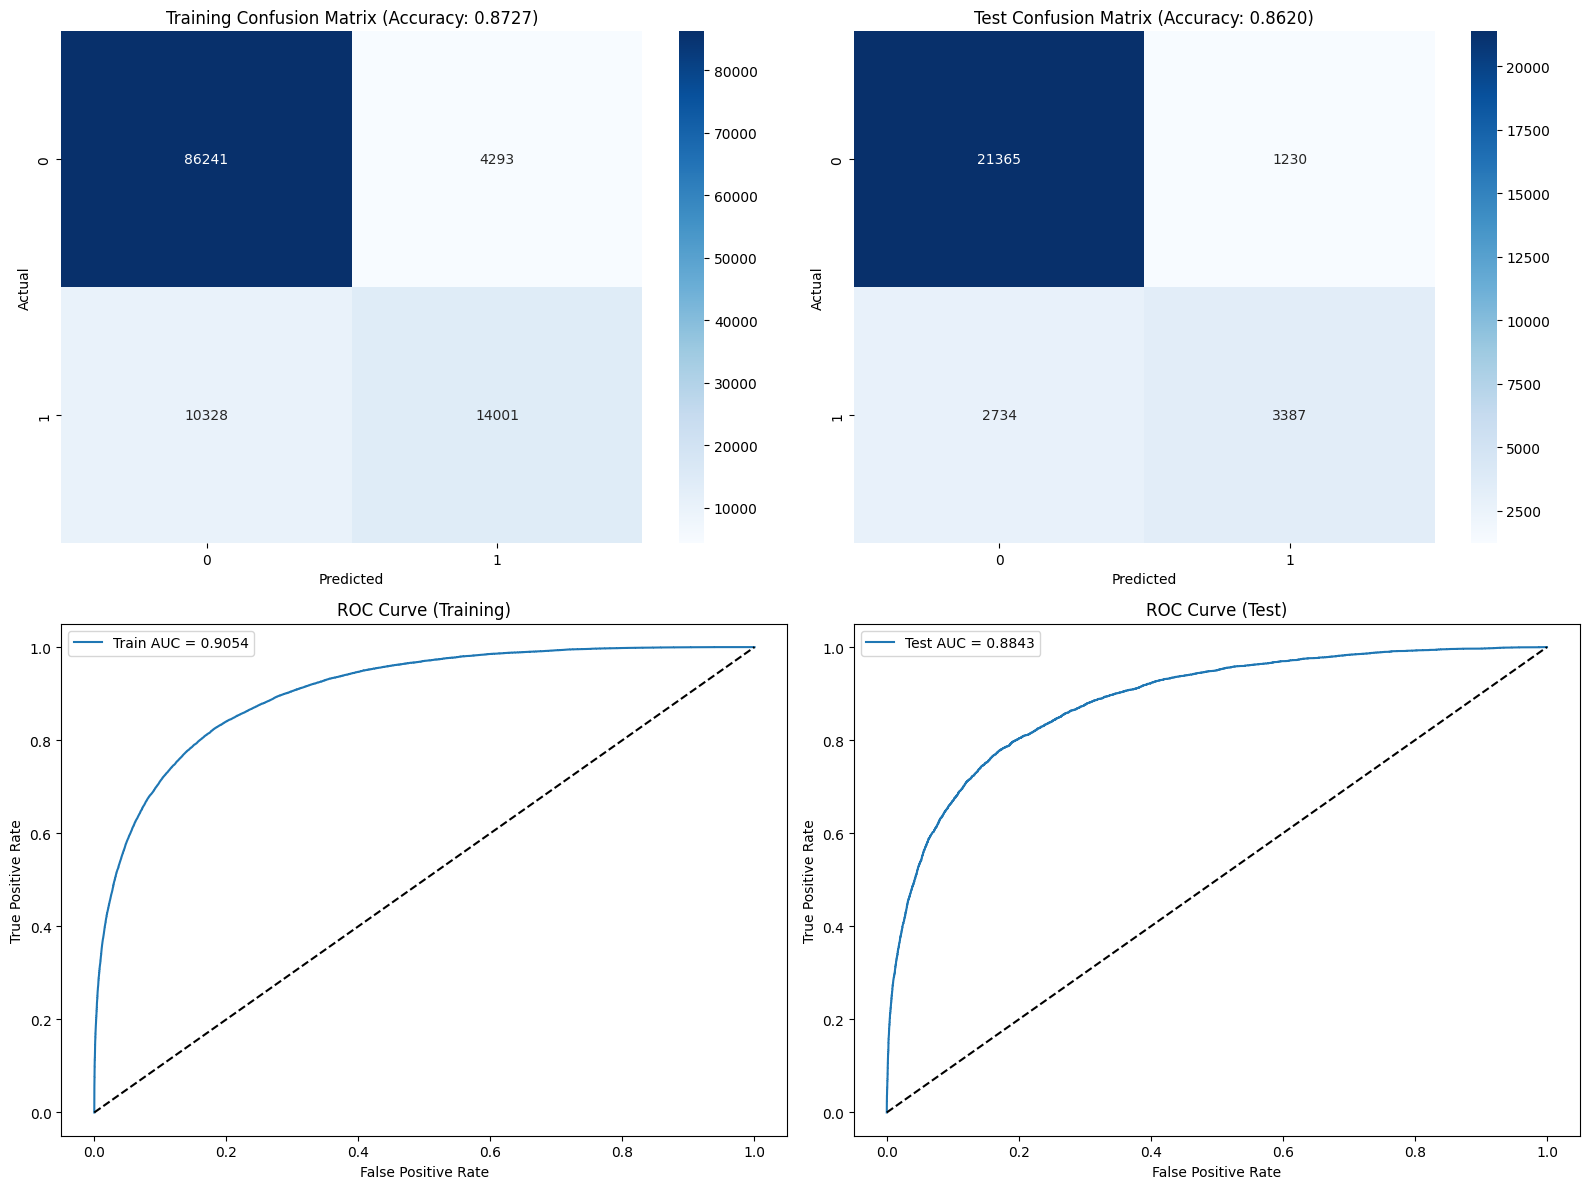

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     90534
           1       0.77      0.58      0.66     24329

    accuracy                           0.87    114863
   macro avg       0.83      0.76      0.79    114863
weighted avg       0.87      0.87      0.87    114863


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22595
           1       0.73      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716



In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for training and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Get probabilities for ROC curve
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC scores
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Set up the figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot confusion matrices
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Training Confusion Matrix (Accuracy: {best_model.score(X_train, y_train):.4f})')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Test Confusion Matrix (Accuracy: {test_score:.4f})')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Plot ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

axes[1, 0].plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.4f}')
axes[1, 0].plot([0, 1], [0, 1], 'k--')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve (Training)')
axes[1, 0].legend()

axes[1, 1].plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.4f}')
axes[1, 1].plot([0, 1], [0, 1], 'k--')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve (Test)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print classification reports
print("Classification Report (Training):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

In [39]:
# On entraine le modèle sur l'ensemble des données
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('numerical',
                                                 Pipeline(steps=[('preprocessor',
                                                                  ColumnTransformer(transformers=[('CreditScore_pipeline',
                                                                                                   Pipeline(steps=[('feature_engineering',
                                                                                                                    GaussianMixtureTransformer(n_components=9))]),
                                                                                                   ['CreditScore']),
                                                                                                  ('EstimatedSalary_pipeline',
                                                                                                   Pipeline(steps=[('feature_engineering',
                                                                                                                    GaussianMixtureTr...
                                                                  StandardScaler())])),
                                                ('categorical',
                                                 ColumnTransformer(transformers=[('onehot_encoder',
                                                                                  OneHotEncoder(drop='first',
                                                                                                sparse_output=False),
                                                                                  ['Geography',
                                                                                   'Gender',
                                                                                   'IsActiveMember']),
                                                                                 ('ordinal_encoder',
                                                                                  OrdinalEncoder(),
                                                                                  ['Tenure',
                                                                                   'NumOfProducts'])],
                                                                   verbose_feature_names_out=False))])),
                ('classifier',
                 GradientBoostingClassifier(loss='exponential',
                                            n_estimators=1200))])

In [40]:
test_df = pd.read_csv("../data/test_data.csv")
result = best_model.predict(test_df)
submission_df = pd.concat(
    [test_df["ID"], pd.DataFrame(result, columns=["Exited"])], axis=1
).set_index("ID")
submission_df.head()

,Exited
ID,
67897,0
163075,0
134760,1
68707,0
3428,0


In [41]:
submission_df.to_csv("../data/submission.csv")
check_df = pd.read_csv("../data/submission.csv")
check_df.head()

,ID,Exited
0,67897,0
1,163075,0
2,134760,1
3,68707,0
4,3428,0
